# atmaCup#9 - スマートショッピングカート

## Import Libraries

In [5]:
# 분석용 라이브러리

import pandas as pd
import numpy as np

In [6]:
# 시각화 라이브러리

import seaborn as sns
from matplotlib_venn import venn2
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use("fivethirtyeight")

font_name = 'NanumBarunGothic'
plt.rc('font', family=font_name)

In [7]:
# 유용한 라이브러리

import os
from time import time
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

## Util Functions

In [8]:
from contextlib import contextmanager
from time import time

@contextmanager
def timer(logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None):
    if prefix: format_str = str(prefix) + format_str
    if suffix: format_str = format_str + str(suffix)
    start = time()
    yield
    d = time() - start
    out_str = format_str.format(d)
    if logger:
        logger.info(out_str)
    else:
        print(out_str)

def savefig(fig, to):
    to = os.path.join(OUTPUT_DIR, to + '.png')
    print('save to {}'.format(to))
    fig.tight_layout()
    fig.savefig(to, dpi=120)

## Investigate Data

In [9]:
INPUT_DIR = 'input/'
OUTPUT_DIR = 'output/'

In [10]:
%%time

# cartlog
log_df = pd.read_csv(os.path.join(INPUT_DIR, 'cartlog.csv'), 
                     dtype={ 'value_1': str }, 
                     parse_dates=['date'])

# meta data
meta_df = pd.read_csv(os.path.join(INPUT_DIR, 'meta.csv'))

# product master
product_master_df = pd.read_csv(os.path.join(INPUT_DIR, 'product_master.csv'), dtype={'JAN':str})

# test data
test_df = pd.read_csv(os.path.join(INPUT_DIR, 'test.csv'))

# User Master
user_df = pd.read_csv(os.path.join(INPUT_DIR, 'user_master.csv'))

# Sample Submission
submission = pd.read_csv(os.path.join(INPUT_DIR, 'atmaCup#9__sample_submission.csv'))

Wall time: 34 s


## EDA

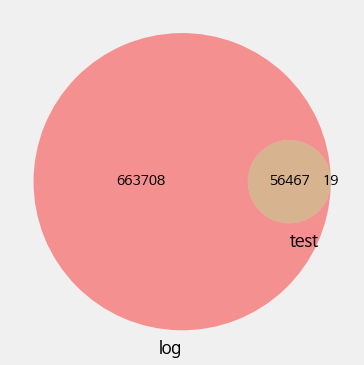

In [16]:
fig, ax = plt.subplots(figsize=(12, 6))

left_set = set(log_df['session_id'].unique())
right_set = set(test_df['session_id'].unique())
venn2(
    subsets=(left_set, right_set),
    set_labels=('log', 'test'), 
    ax=ax)

plt.show()

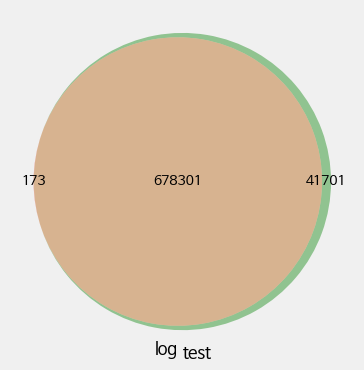

In [20]:
fig, ax = plt.subplots(figsize=(12, 6))

left_set = set(log_df[log_df['kind_1']=='商品']['session_id'].unique())
right_set = set(log_df[log_df['kind_1']!='商品']['session_id'].unique())
venn2(
    subsets=(left_set, right_set),
    set_labels=('log', 'test'), 
    ax=ax)

plt.show()

## EDA

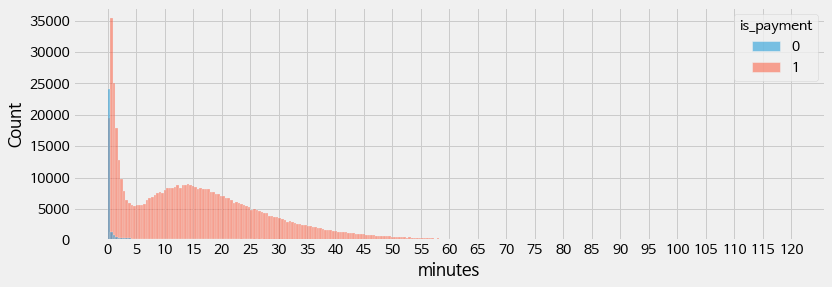

In [63]:
# 세션 별 최대 시간 분포
groupby_session = only_in_log_df.groupby('session_id')
_df = pd.concat([
    groupby_session['spend_time'].max().rename('minutes') / 60,
    groupby_session['is_payment'].sum()
], axis=1)

_df = _df[_df['minutes'] <= 120]

fig, ax = plt.subplots(figsize=(12, 4))
sns.histplot(data=_df, x='minutes', hue='is_payment', ax=ax)
plt.xticks(np.arange(0,125,5))
plt.show()

<AxesSubplot:xlabel='spend_time_cut', ylabel='total_items'>

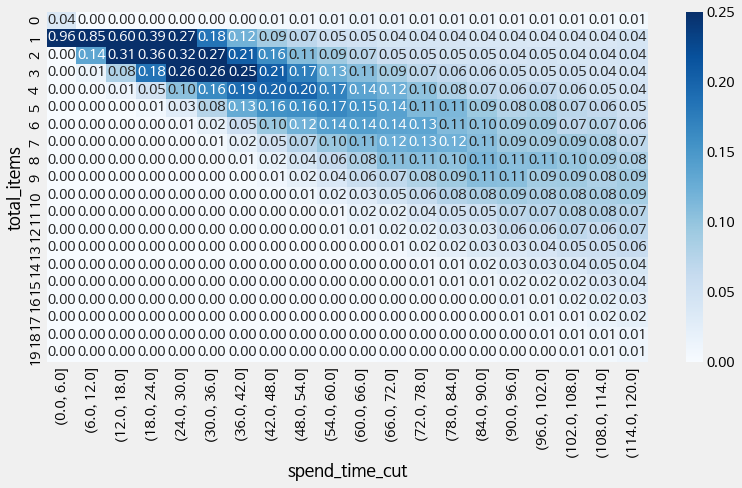

In [70]:
# 구매시간과 구입 상품 갯수 (품목 X)의 관계성
groupby_session = payed_session_df.groupby('session_id')
_df = pd.concat([
    groupby_session['n_items'].sum().rename('total_items'),
    groupby_session['spend_time'].max()
], axis=1)

_df['spend_time_cut'] = pd.cut(_df['spend_time'], bins=np.linspace(0, 120, 21))
_df.dropna(0, inplace=True)

_df = pd.pivot_table(data=_df, 
                     index='total_items', 
                     columns='spend_time_cut', 
                     values='spend_time', 
                     aggfunc='size').fillna(0)

_df = _df.div(_df.sum(), axis=1)
_df = _df.reindex(range(20))

fig, ax = plt.subplots(figsize=(12, 6))
sns.heatmap(_df, ax=ax, cmap='Blues', vmax=.25, annot=True, fmt='.2f')

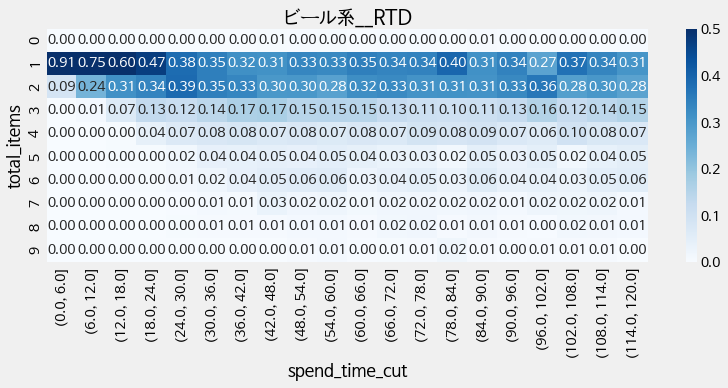

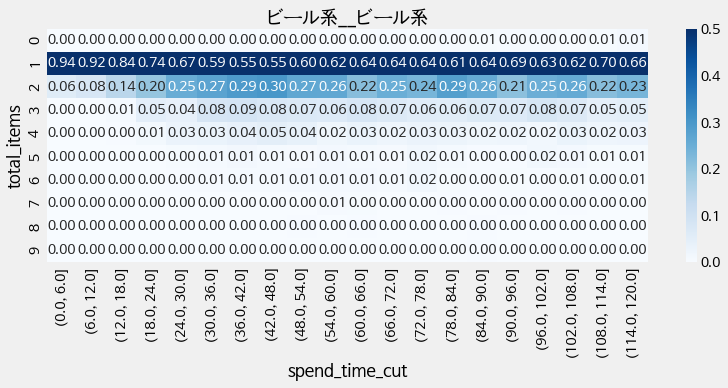

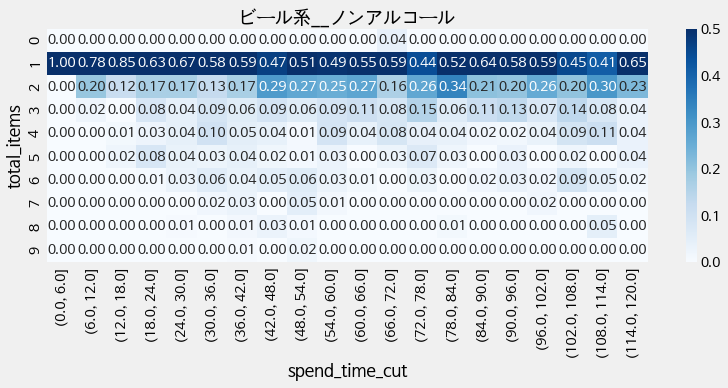

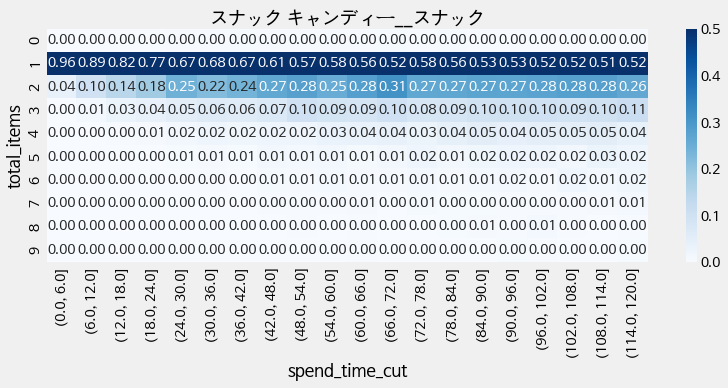

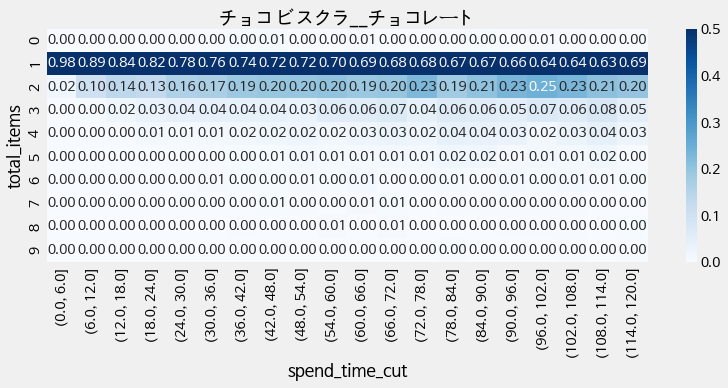

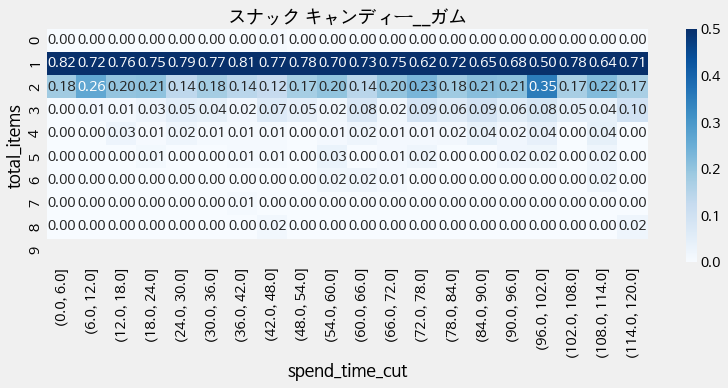

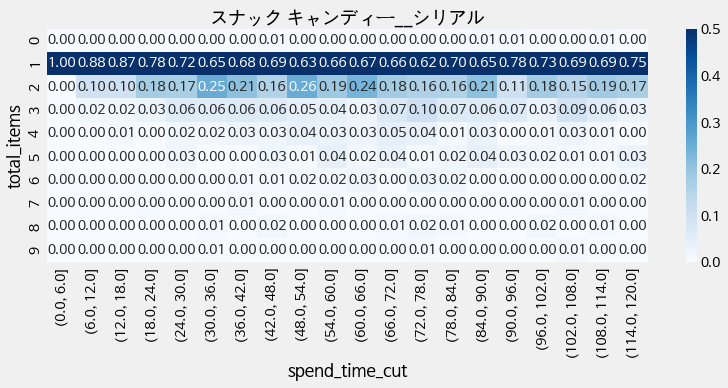

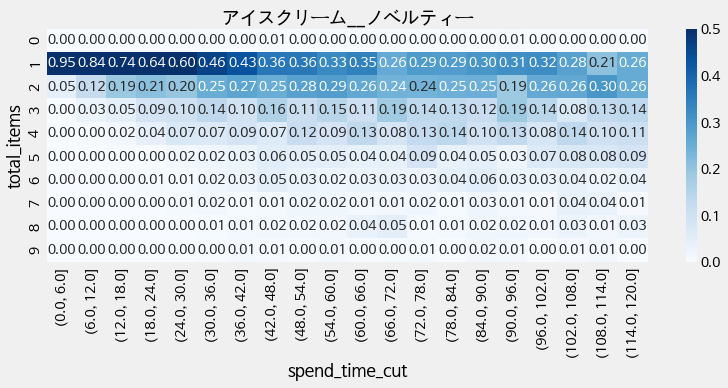

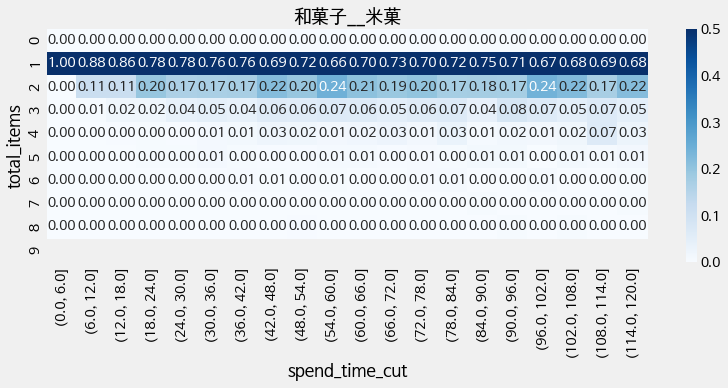

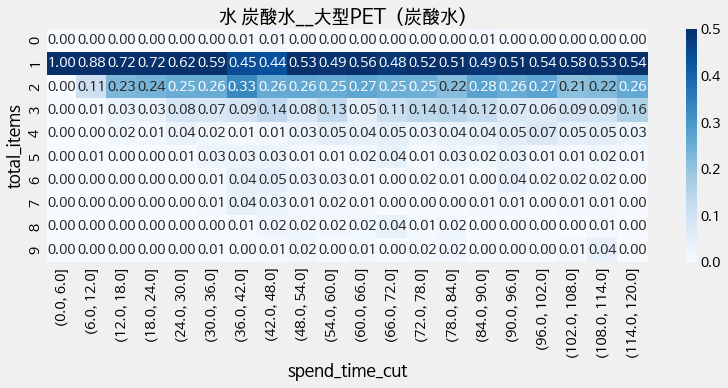

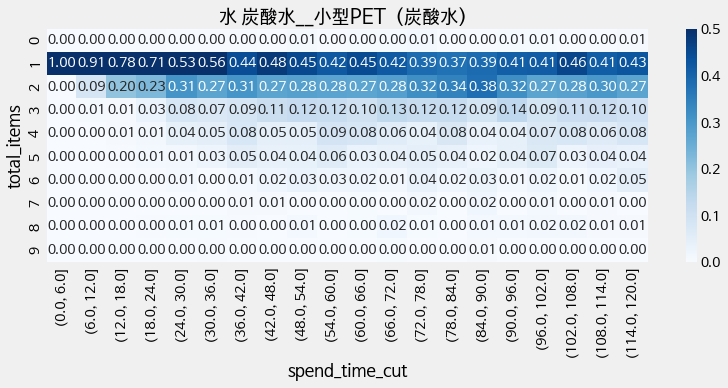

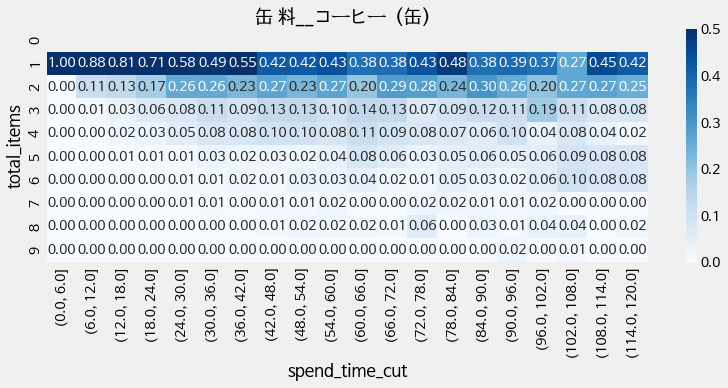

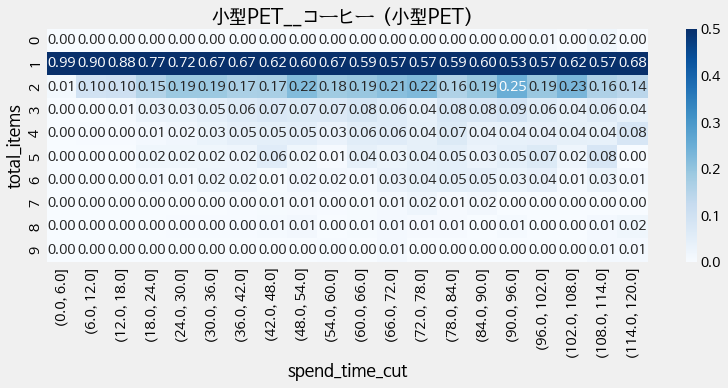

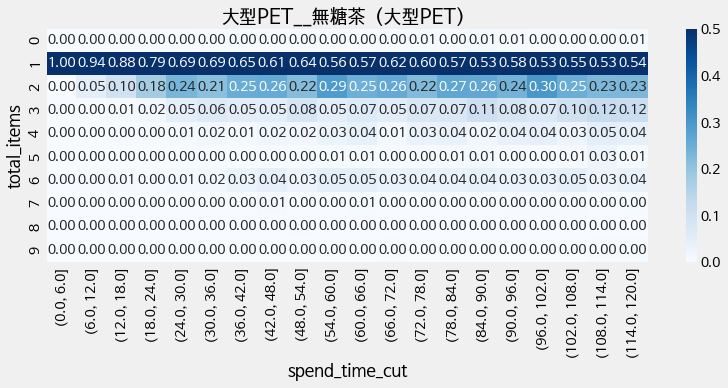

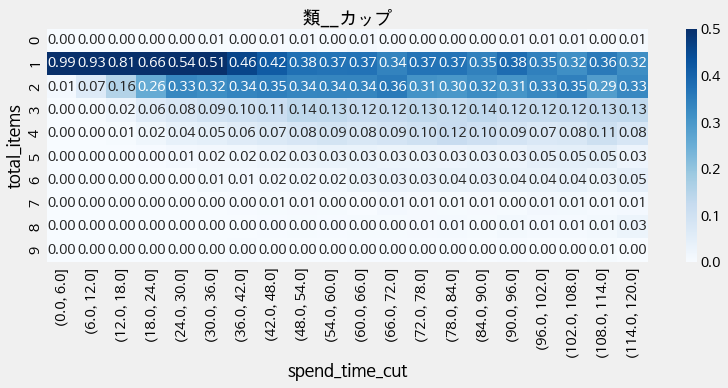

In [74]:
# 구매시간과 타겟 상품의 구입 갯수의 관계성

for target_name in TARGET_CATEGORIES:
    target_id = cat2id[target_name]
    jans = product_master_df[product_master_df['category_id']==target_id]['JAN'].unique()
    
    idx = payed_session_df['value_1'].isin(jans)
    
    groupby_session = payed_session_df[idx].groupby('session_id')
    _df = pd.concat([
        groupby_session['n_items'].sum().rename('total_items'),
        groupby_session['spend_time'].max()
    ], axis=1)

    _df['spend_time_cut'] = pd.cut(_df['spend_time'], bins=np.linspace(0, 120, 21))
    _df.dropna(0, inplace=True)

    _df = pd.pivot_table(data=_df, 
                         index='total_items', 
                         columns='spend_time_cut', 
                         values='spend_time', 
                         aggfunc='size').fillna(0)

    _df = _df.div(_df.sum(), axis=1)
    _df = _df.reindex(range(10))

    fig, ax = plt.subplots(figsize=(12, 4))
    sns.heatmap(_df, ax=ax, cmap='Blues', vmax=.5, annot=True, fmt='.2f')
    plt.title(f'{target_name}')
    plt.show()